In [2]:
import requests
import pandas as pd
from io import StringIO
import html
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def usgs_water_api_pull(
        startDT="2000-01-01", 
        endDT="2024-09-06", 
        stateCd="CO", 
        siteStatus="all", 
        altMin=0):
    """API reference: https://waterservices.usgs.gov/test-tools/"""
    url = "https://waterservices.usgs.gov/nwis/dv/"
    params = {
        "format": "json",
        "stateCd": stateCd,
        "startDT": startDT,
        "endDT": endDT,
        "siteStatus": siteStatus,
        "altMin": altMin
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    print(response.url)
    data = response.json()

    # Flatten the timeSeries object without expanding the list elements
    df_flat = pd.json_normalize(
        data['value']['timeSeries'],
        sep='_',
        errors='ignore'
    )

    # Expand the 'values.value' field manually (since it's a list of dicts)
    expanded_values = []
    for i, row in df_flat.iterrows():
        for value_entry in row['values']:
            for val in value_entry['value']:
                expanded_values.append({
                    'siteName': row['sourceInfo_siteName'],
                    'siteCode': row['sourceInfo_siteCode'][0]['value'],
                    'variableName': row['variable_variableName'],
                    'unitCode': row['variable_unit_unitCode'],
                    'dateTime': val['dateTime'],
                    'value': val['value']
                })
    df = pd.DataFrame(expanded_values)

    def clean_html(text):
        text = html.unescape(text)
        text = re.sub(r'<.*?>', '', text)
        return text
    
    df = df.map(lambda x: clean_html(x) if isinstance(x, str) else x)

    return df

df = usgs_water_api_pull()

https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=CO&startDT=2000-01-01&endDT=2024-09-06&siteStatus=all&altMin=0


In [6]:
# Cleaning
df_streamflow = df[df['variableName'] == 'Streamflow, ft³/s']
df_streamflow = df_streamflow[['siteName', 'siteCode', 'dateTime', 'value']]
df_streamflow = df_streamflow.rename(columns={'value': 'streamflow'})

df_precipitation = df[df['variableName'] == 'Precipitation, total, in']
df_precipitation = df_precipitation[['siteName', 'siteCode', 'dateTime', 'value']]
df_precipitation = df_precipitation.rename(columns={'value': 'precipitation'})

df_joined = df_streamflow.merge(
    df_precipitation, on=['siteName', 'siteCode', 'dateTime'], how='left')

df_joined = df_joined.fillna(0.0).convert_dtypes()
df_joined['dateTime'] = pd.to_datetime(df_joined['dateTime'])
df_joined['streamflow'] = df_joined['streamflow'].astype(float)
df_joined['precipitation'] = df_joined['precipitation'].astype(float)
df_joined = df_joined[df_joined['streamflow'] >= 0.0]
df_joined = df_joined[df_joined['precipitation'] >= 0.0]

df_final = df_joined.copy()
del df_joined
display(df_final.info())
display(df_final.isnull().sum())
display(df_final)

df_final.to_parquet('data/usgs_water_data.parquet', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2619518 entries, 0 to 2623056
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   siteName       string        
 1   siteCode       string        
 2   dateTime       datetime64[ns]
 3   streamflow     float64       
 4   precipitation  float64       
dtypes: datetime64[ns](1), float64(2), string(2)
memory usage: 119.9 MB


None

siteName         0
siteCode         0
dateTime         0
streamflow       0
precipitation    0
dtype: int64

,siteName,siteCode,dateTime,streamflow,precipitation
0,HELL CREEK ABV NF NORTH PLATTE RIVER NR WALDEN...,06613950,2014-08-21,11.8,0.0
1,HELL CREEK ABV NF NORTH PLATTE RIVER NR WALDEN...,06613950,2014-08-22,11.4,0.0
2,HELL CREEK ABV NF NORTH PLATTE RIVER NR WALDEN...,06613950,2014-08-23,13.1,0.0
3,HELL CREEK ABV NF NORTH PLATTE RIVER NR WALDEN...,06613950,2014-08-24,11.4,0.0
4,HELL CREEK ABV NF NORTH PLATTE RIVER NR WALDEN...,06613950,2014-08-25,12.4,0.0
...,...,...,...,...,...
2623052,"BIG THOMPSON BL MORAINE PARK NR ESTES PARK, CO",402114105350101,2024-09-02,19.6,0.0
2623053,"BIG THOMPSON BL MORAINE PARK NR ESTES PARK, CO",402114105350101,2024-09-03,18.7,0.0
2623054,"BIG THOMPSON BL MORAINE PARK NR ESTES PARK, CO",402114105350101,2024-09-04,19.6,0.0
2623055,"BIG THOMPSON BL MORAINE PARK NR ESTES PARK, CO",402114105350101,2024-09-05,23.8,0.0


In [3]:
df = pd.read_parquet('data/usgs_water_data.parquet')
print(f"Rows: {df.shape[0]:,}")

Rows: 2,619,518


In [33]:
df_filtered = df[df['siteName'].str.contains('COLORADO RIVER BELOW GLENWOOD SPRINGS, CO')].reset_index(drop=True)
display(df_filtered)

,siteName,siteCode,dateTime,streamflow,precipitation
0,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2000-01-01,1420.0,0.0
1,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2000-01-02,1520.0,0.0
2,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2000-01-03,1480.0,0.0
3,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2000-01-04,1230.0,0.0
4,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2000-01-05,1420.0,0.0
...,...,...,...,...,...
9011,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2024-09-02,1890.0,0.0
9012,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2024-09-03,1880.0,0.0
9013,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2024-09-04,1840.0,0.0
9014,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",09085100,2024-09-05,1940.0,0.0


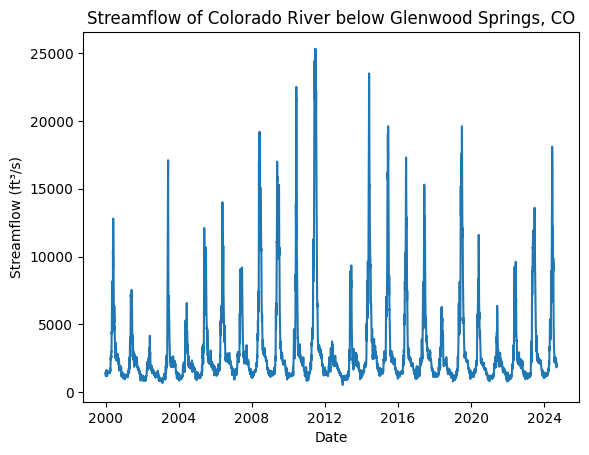

In [6]:
# Visualize Streamflow
sns.lineplot(data=df_filtered, x='dateTime', y='streamflow', hue='siteName', legend=False)
plt.title('Streamflow of Colorado River below Glenwood Springs, CO')
plt.xlabel('Date')
plt.ylabel('Streamflow (ft³/s)')
plt.show()

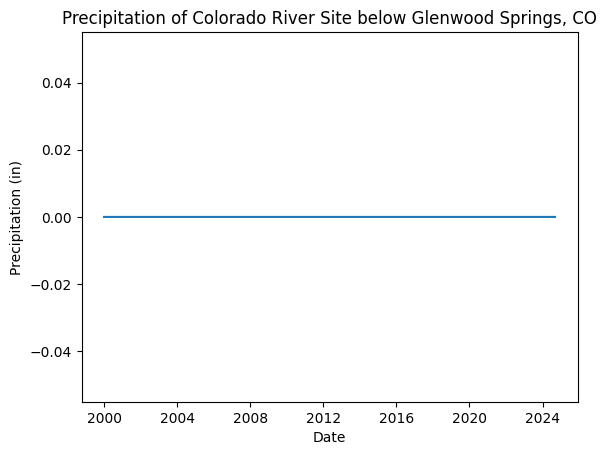

In [7]:
# Visualize Precipitation
sns.lineplot(data=df_filtered, x='dateTime', y='precipitation', hue='siteName', legend=False)
plt.title('Precipitation of Colorado River Site below Glenwood Springs, CO')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.show()

Will drop precipitation based on lack of data.

In [6]:
# Drop columns
df_filtered = df[df['siteName'].str.contains('COLORADO RIVER BELOW GLENWOOD SPRINGS, CO')].reset_index(drop=True)
df_filtered['date'] = pd.to_datetime(df['dateTime'])
df_filtered = df_filtered.drop(columns=['precipitation', 'dateTime', 'siteName', 'siteCode'])
df_filtered = df_filtered.dropna().drop_duplicates()
df_filtered = df_filtered.set_index('date')
print(f"Rows: {df_filtered.shape[0]:,}")
print(f"Unique Dates: {df_filtered.index.nunique():,}")
df_grouped = df_filtered.groupby(by='date').mean()
display(df_grouped)

df_grouped.to_parquet('data/usgs_colorado_river_glenwood_springs.parquet')

Rows: 9,016
Unique Dates: 8,792


,streamflow
date,
2000-01-01,2510.0
2000-01-02,2570.0
2000-01-03,2580.0
2000-01-04,2540.0
2000-01-05,2500.0
...,...
2024-01-22,1890.0
2024-01-23,1880.0
2024-01-24,1840.0
